In [1]:
import os
import sys
import time
import datetime
import re
import multiprocessing

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14}

# sns.set(rc=rc)

from scipy import ndimage as ndi
import scipy as scp
import pandas as pd

import matplotlib.animation as anm
from IPython.display import HTML

from skimage.external.tifffile import TiffWriter

from PIL import Image

import skimage.filters
import skimage.io
import skimage.morphology
import skimage.feature
import skimage.exposure

from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte

from bokeh.plotting import figure
from bokeh.io import output_notebook, show
from bokeh import palettes, transform

rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 24, 
      'xtick.labelsize': 18, 
      'ytick.labelsize': 18, 
      'legend.fontsize': 18,
      'axes.facecolor': 'fbfbfc'}
sns.set_context('talk', rc=rc)

%matplotlib inline
output_notebook()

nb_prefix = "180509"

Loading BokehJS ...

In [2]:

def write_movie(im_arr, skip=1, maxframe=100):
    plt.close('all')
    
    t, s, c, h, w = im_arr.shape
    im_out = np.zeros((t,3,h,5*w))
    
    # First set up the figure, the axis, and the plot element we want to animate
    blank_array = np.zeros([h, 5*w, 3])
    gray_array = np.ones([h, w, 3])
    red_array = np.zeros([h, w, 3])
    red_array[:,:,0] = 1#np.ones([h, w])
    red_array[:,:,1] = 0#np.ones([h, w]) * 0.0
    red_array[:,:,2] = 0#np.ones([h, w]) * 0.0
    cyan_array = np.zeros([h, w, 3])
    cyan_array[:,:,0] = 0#np.ones([h, w]) * 0.0
    cyan_array[:,:,1] = 1#np.ones([h, w]) 
    cyan_array[:,:,2] = 1#np.ones([h, w])
    fig, axs = plt.subplots(3,1, dpi=175, figsize=(5,4))
    im_list = [0,0,0]
    
    # Plot cell densities
    ax = axs[0]
    im = ax.imshow(blank_array, animated=True, interpolation='none')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('Inactive Senders, active propagation')
    im_list[0] = im
    
    # Plot nutrient densities
    ax = axs[1]
    im = ax.imshow(blank_array, animated=True, interpolation='none')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('Active Senders, active propagation')
    im_list[1] = im
    
    # Plot synthase densities
    ax = axs[2]
    im = ax.imshow(blank_array, animated=True, interpolation='none')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('Active Senders, passive propagation')
    im_list[2] = im
#     fig.tight_layout()
    def animate(i):
        
        min_v = [15e3, 100, 100]
        max_v = [30e3, 5e2, 5e2]
        
        # Plot cell densities
        ax = axs[0]
        frame = np.zeros([h, 5*w, 3])
        for c, c_array in enumerate([gray_array, red_array, cyan_array]):
            for p, p_i in enumerate([2,1,0]):
                d_arr = (im_all[i,p_i,c,:,:] - min_v[c]) / (max_v[c] - min_v[c])
#                 d_arr[d_arr > 1 ] = 1
#                 d_arr[d_arr < 0 ] = 0
                frame[:,(2*w*p):(2*w*(1+p)-w),:] += c_array * np.stack(3*[d_arr], axis=2)
        frame[frame > 1 ] = 1
        frame[frame < 0 ] = 0
        im_list[0].set_array(frame)

        min_v = [5e3,  100, 100]
        max_v = [27e3, 5e2, 5e2]
        # Plot nutrient densities
        ax = axs[1]
        frame = np.zeros([h, 5*w, 3])
        for c, c_array in enumerate([gray_array, red_array, cyan_array]):
            for p, p_i in enumerate([5,4,3]):
                d_arr = (im_all[i,p_i,c,:,:] - min_v[c]) / (max_v[c] - min_v[c])
#                 d_arr[d_arr > 1 ] = 1
#                 d_arr[d_arr < 0 ] = 0
                frame[:,(2*w*p):(2*w*(1+p)-w),:] += c_array * np.stack(3*[d_arr], axis=2)
        frame[frame > 1 ] = 1
        frame[frame < 0 ] = 0
        im_list[1].set_array(frame)

        
        min_v = [15e3, 100, 100]
        max_v = [30e3, 5e2, 5e2]
        # Plot synthase densities
        ax = axs[2]
        frame = np.zeros([h, 5*w, 3])
        for c, c_array in enumerate([gray_array, red_array, cyan_array]):
            for p, p_i in enumerate([8,7,6]):
                d_arr = (im_all[i,p_i,c,:,:] - min_v[c]) / (max_v[c] - min_v[c])
#                 d_arr[d_arr > 1 ] = 1
#                 d_arr[d_arr < 0 ] = 0
                frame[:,(2*w*p):(2*w*(1+p)-w),:] += c_array * np.stack(3*[d_arr], axis=2)
        frame[frame > 1 ] = 1
        frame[frame < 0 ] = 0
        im_list[2].set_array(frame)
        
        #return im_list,

    # call the animator.  blit=True means only re-draw the parts that have changed.
    writer = anm.ImageMagickFileWriter(20)
    anim = anm.FuncAnimation(fig, animate, interval=50, frames=np.arange(0, maxframe, skip))

    anim.save('animation_pulse.gif', writer=writer)
    plt.close('all')
    return anim
    #HTML(anim.to_html5_video())

# anim = write_movie(im_all, skip=1, maxframe=80)
# HTML(anim.to_html5_video())

In [43]:
summ_dict = {
    "Slices": 1,
    "InitialPositionList": [
      {
        "DeviceCoordinatesUm": {
          "ManualFocus": [2711.6],
          "XYStage": [
            -45998.8,
            -9138
          ]
        },
        "GridColumnIndex": 0,
        "Label": "p0-0",
        "GridRowIndex": 0
      },
      {
        "DeviceCoordinatesUm": {
          "ManualFocus": [2714.57],
          "XYStage": [
            -42747.1,
            -9718
          ]
        },
        "GridColumnIndex": 0,
        "Label": "p0-1",
        "GridRowIndex": 0
      },
      {
        "DeviceCoordinatesUm": {
          "ManualFocus": [2721.58],
          "XYStage": [
            -38217.200000000004,
            -9528.5
          ]
        },
        "GridColumnIndex": 0,
        "Label": "p0-2",
        "GridRowIndex": 0
      },
      {
        "DeviceCoordinatesUm": {
          "ManualFocus": [2717.61],
          "XYStage": [
            -50837.4,
            -1812.5
          ]
        },
        "GridColumnIndex": 0,
        "Label": "p1-0",
        "GridRowIndex": 0
      },
      {
        "DeviceCoordinatesUm": {
          "ManualFocus": [2720.17],
          "XYStage": [
            -46063.200000000004,
            -1950.1000000000001
          ]
        },
        "GridColumnIndex": 0,
        "Label": "p1-1",
        "GridRowIndex": 0
      },
      {
        "DeviceCoordinatesUm": {
          "ManualFocus": [2718.84],
          "XYStage": [
            -43704.9,
            -1424.7
          ]
        },
        "GridColumnIndex": 0,
        "Label": "p1-2",
        "GridRowIndex": 0
      },
      {
        "DeviceCoordinatesUm": {
          "ManualFocus": [2729.5],
          "XYStage": [
            -48642.4,
            8712.9
          ]
        },
        "GridColumnIndex": 0,
        "Label": "p2-0",
        "GridRowIndex": 0
      },
      {
        "DeviceCoordinatesUm": {
          "ManualFocus": [2730.19],
          "XYStage": [
            -46223.4,
            8557.5
          ]
        },
        "GridColumnIndex": 0,
        "Label": "p2-1",
        "GridRowIndex": 0
      },
      {
        "DeviceCoordinatesUm": {
          "ManualFocus": [2729.32],
          "XYStage": [
            -43618.6,
            9475.9
          ]
        },
        "GridColumnIndex": 0,
        "Label": "p2-2",
        "GridRowIndex": 0
      }
    ]}

all_dict = {
   "VERSION": 3,
   "ID": "Micro-Manager XY-position list",
   "POSITIONS": [
      {
         "GRID_COL": 0,
         "DEVICES": [
            {
               "DEVICE": "ManualFocus",
               "AXES": 1,
               "Y": 0,
               "X": 2713.93,
               "Z": 0
            },
            {
               "DEVICE": "XYStage",
               "AXES": 2,
               "Y": -8317.9,
               "X": -49668.3,
               "Z": 0
            }
         ],
         "PROPERTIES": {},
         "DEFAULT_Z_STAGE": "ManualFocus",
         "LABEL": "p1_proxend",
         "GRID_ROW": 0,
         "DEFAULT_XY_STAGE": "XYStage"
      },
      {
         "GRID_COL": 0,
         "DEVICES": [
            {
               "DEVICE": "ManualFocus",
               "AXES": 1,
               "Y": 0,
               "X": 2713.93,
               "Z": 0
            },
            {
               "DEVICE": "XYStage",
               "AXES": 2,
               "Y": -9138,
               "X": -45998.8,
               "Z": 0
            }
         ],
         "PROPERTIES": {},
         "DEFAULT_Z_STAGE": "ManualFocus",
         "LABEL": "p0-0",
         "GRID_ROW": 0,
         "DEFAULT_XY_STAGE": "XYStage"
      },
      {
         "GRID_COL": 0,
         "DEVICES": [
            {
               "DEVICE": "ManualFocus",
               "AXES": 1,
               "Y": 0,
               "X": 2713.93,
               "Z": 0
            },
            {
               "DEVICE": "XYStage",
               "AXES": 2,
               "Y": -9718.1,
               "X": -42747,
               "Z": 0
            }
         ],
         "PROPERTIES": {},
         "DEFAULT_Z_STAGE": "ManualFocus",
         "LABEL": "p0-1",
         "GRID_ROW": 0,
         "DEFAULT_XY_STAGE": "XYStage"
      },
      {
         "GRID_COL": 0,
         "DEVICES": [
            {
               "DEVICE": "ManualFocus",
               "AXES": 1,
               "Y": 0,
               "X": 2713.93,
               "Z": 0
            },
            {
               "DEVICE": "XYStage",
               "AXES": 2,
               "Y": -9528.6,
               "X": -38217.1,
               "Z": 0
            }
         ],
         "PROPERTIES": {},
         "DEFAULT_Z_STAGE": "ManualFocus",
         "LABEL": "p0-2",
         "GRID_ROW": 0,
         "DEFAULT_XY_STAGE": "XYStage"
      },
      {
         "GRID_COL": 0,
         "DEVICES": [
            {
               "DEVICE": "ManualFocus",
               "AXES": 1,
               "Y": 0,
               "X": 2713.93,
               "Z": 0
            },
            {
               "DEVICE": "XYStage",
               "AXES": 2,
               "Y": -10523.4,
               "X": -27874.600000000002,
               "Z": 0
            }
         ],
         "PROPERTIES": {},
         "DEFAULT_Z_STAGE": "ManualFocus",
         "LABEL": "p1_distend",
         "GRID_ROW": 0,
         "DEFAULT_XY_STAGE": "XYStage"
      },
      {
         "GRID_COL": 0,
         "DEVICES": [
            {
               "DEVICE": "ManualFocus",
               "AXES": 1,
               "Y": 0,
               "X": 2713.93,
               "Z": 0
            },
            {
               "DEVICE": "XYStage",
               "AXES": 2,
               "Y": 499.6,
               "X": -56019.3,
               "Z": 0
            }
         ],
         "PROPERTIES": {},
         "DEFAULT_Z_STAGE": "ManualFocus",
         "LABEL": "p2_proxend",
         "GRID_ROW": 0,
         "DEFAULT_XY_STAGE": "XYStage"
      },
      {
         "GRID_COL": 0,
         "DEVICES": [
            {
               "DEVICE": "ManualFocus",
               "AXES": 1,
               "Y": 0,
               "X": 2720.79,
               "Z": 0
            },
            {
               "DEVICE": "XYStage",
               "AXES": 2,
               "Y": -1812.5,
               "X": -50837.4,
               "Z": 0
            }
         ],
         "PROPERTIES": {},
         "DEFAULT_Z_STAGE": "ManualFocus",
         "LABEL": "p1-0",
         "GRID_ROW": 0,
         "DEFAULT_XY_STAGE": "XYStage"
      },
      {
         "GRID_COL": 0,
         "DEVICES": [
            {
               "DEVICE": "ManualFocus",
               "AXES": 1,
               "Y": 0,
               "X": 2720.79,
               "Z": 0
            },
            {
               "DEVICE": "XYStage",
               "AXES": 2,
               "Y": -1950.4,
               "X": -46063.200000000004,
               "Z": 0
            }
         ],
         "PROPERTIES": {},
         "DEFAULT_Z_STAGE": "ManualFocus",
         "LABEL": "p1-1",
         "GRID_ROW": 0,
         "DEFAULT_XY_STAGE": "XYStage"
      },
      {
         "GRID_COL": 0,
         "DEVICES": [
            {
               "DEVICE": "ManualFocus",
               "AXES": 1,
               "Y": 0,
               "X": 2720.79,
               "Z": 0
            },
            {
               "DEVICE": "XYStage",
               "AXES": 2,
               "Y": -1424.8,
               "X": -43704.5,
               "Z": 0
            }
         ],
         "PROPERTIES": {},
         "DEFAULT_Z_STAGE": "ManualFocus",
         "LABEL": "p1-2",
         "GRID_ROW": 0,
         "DEFAULT_XY_STAGE": "XYStage"
      },
      {
         "GRID_COL": 0,
         "DEVICES": [
            {
               "DEVICE": "ManualFocus",
               "AXES": 1,
               "Y": 0,
               "X": 2720.79,
               "Z": 0
            },
            {
               "DEVICE": "XYStage",
               "AXES": 2,
               "Y": -1455.4,
               "X": -34172.9,
               "Z": 0
            }
         ],
         "PROPERTIES": {},
         "DEFAULT_Z_STAGE": "ManualFocus",
         "LABEL": "p2_distend",
         "GRID_ROW": 0,
         "DEFAULT_XY_STAGE": "XYStage"
      },
      {
         "GRID_COL": 0,
         "DEVICES": [
            {
               "DEVICE": "ManualFocus",
               "AXES": 1,
               "Y": 0,
               "X": 2720.79,
               "Z": 0
            },
            {
               "DEVICE": "XYStage",
               "AXES": 2,
               "Y": 8610.2,
               "X": -54875,
               "Z": 0
            }
         ],
         "PROPERTIES": {},
         "DEFAULT_Z_STAGE": "ManualFocus",
         "LABEL": "p3_proxend",
         "GRID_ROW": 0,
         "DEFAULT_XY_STAGE": "XYStage"
      },
      {
         "GRID_COL": 0,
         "DEVICES": [
            {
               "DEVICE": "ManualFocus",
               "AXES": 1,
               "Y": 0,
               "X": 2731.69,
               "Z": 0
            },
            {
               "DEVICE": "XYStage",
               "AXES": 2,
               "Y": 8712.9,
               "X": -48642.4,
               "Z": 0
            }
         ],
         "PROPERTIES": {},
         "DEFAULT_Z_STAGE": "ManualFocus",
         "LABEL": "p2-0",
         "GRID_ROW": 0,
         "DEFAULT_XY_STAGE": "XYStage"
      },
      {
         "GRID_COL": 0,
         "DEVICES": [
            {
               "DEVICE": "ManualFocus",
               "AXES": 1,
               "Y": 0,
               "X": 2731.69,
               "Z": 0
            },
            {
               "DEVICE": "XYStage",
               "AXES": 2,
               "Y": 8557.5,
               "X": -46223.4,
               "Z": 0
            }
         ],
         "PROPERTIES": {},
         "DEFAULT_Z_STAGE": "ManualFocus",
         "LABEL": "p2-1",
         "GRID_ROW": 0,
         "DEFAULT_XY_STAGE": "XYStage"
      },
      {
         "GRID_COL": 0,
         "DEVICES": [
            {
               "DEVICE": "ManualFocus",
               "AXES": 1,
               "Y": 0,
               "X": 2731.69,
               "Z": 0
            },
            {
               "DEVICE": "XYStage",
               "AXES": 2,
               "Y": 9475.9,
               "X": -43618.3,
               "Z": 0
            }
         ],
         "PROPERTIES": {},
         "DEFAULT_Z_STAGE": "ManualFocus",
         "LABEL": "p2-2",
         "GRID_ROW": 0,
         "DEFAULT_XY_STAGE": "XYStage"
      }
   ]
}
n_p = len(all_dict['POSITIONS'])
all_dict['POSITIONS'][0]['DEVICES'][1]

{'DEVICE': 'XYStage', 'AXES': 2, 'Y': -8317.9, 'X': -49668.3, 'Z': 0}

pandas.core.series.Series

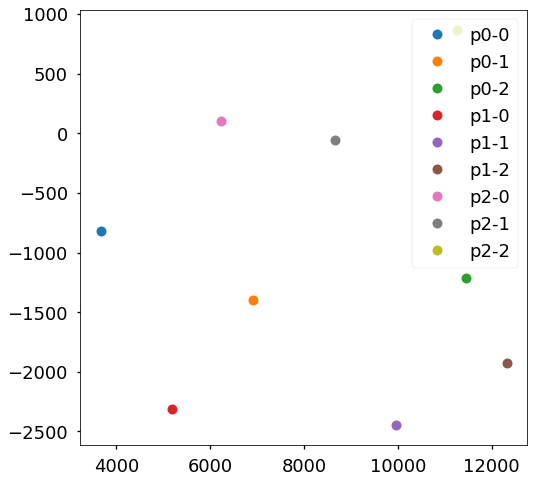

In [94]:
all_pos_df = pd.DataFrame(np.empty((n_p,3)),columns=['x','y','label'])
for p_i in np.arange(n_p):
    sub_dict = all_dict['POSITIONS'][p_i]['DEVICES'][1]
    x = np.float(sub_dict['X'])
    y = np.float(sub_dict['Y'])
    label = all_dict['POSITIONS'][p_i]['LABEL']
    all_pos_df.loc[p_i,['x', 'y', 'label']] = [x, y, label]

cor_pos_df = pd.DataFrame(np.empty((9,3)),columns=['x','y','label'])
for p_i in np.arange(9):
    x, y = summ_dict['InitialPositionList'][p_i]['DeviceCoordinatesUm']['XYStage']
    label = summ_dict['InitialPositionList'][p_i]['Label']
    if label[:2] == 'p0':
        prox_position = all_pos_df.loc[all_pos_df.label == 'p1_proxend', ['x', 'y']]
        x = x - prox_position.x
        y = y - prox_position.y
    if label[:2] == 'p1':
        prox_position = all_pos_df.loc[all_pos_df.label == 'p2_proxend', ['x', 'y']]
        x = x - prox_position.x
        y = y - prox_position.y
    if label[:2] == 'p2':
        prox_position = all_pos_df.loc[all_pos_df.label == 'p3_proxend', ['x', 'y']]
        x = x - prox_position.x
        y = y - prox_position.y
    cor_pos_df.loc[p_i,['x', 'y', 'label']] = [x, y, label]

plt.figure(figsize=(8,8))
for p_i in np.arange(9):
    plt.plot(np.float(cor_pos_df.x[p_i]), np.float(cor_pos_df.y[p_i]), '.', label=cor_pos_df.label[p_i],ms=20)
# plt.plot(pos_df.x, pos_df.y, '.')
plt.legend()
type(x)

In [9]:
chan_ind = ['0','3','5']
channel = ['Brightfield', 'mScarlet', 'sfCFP']
chan_dict = dict(zip(chan_ind, channel))

positions_list = np.array([[-40625.8, -10535],
[-46528.3, -11128.5],
[-51017.700000000004, -10743.300000000001],
[-35944.1, -1774.4],
[-41484.700000000004, -1774.4],
[-46853.3, -2937.8],
[-38918.4, 5655.5],
[-43622.9, 4457.8],
[-48408.6, 3854.5]])

# epoch_zero = 1518161340

def img_metadata_dict(img):
    '''Read creation time from the TIFF metadata in seconds from Epoch'''
    metadata_key = 50839
    metadata_str = img.tag[metadata_key].decode('utf-8').replace("\x00","")
    splits = re.split(",",metadata_str)
    metadata_keys = []
    metadata_vals = []
    for split_x in splits:
        hits = re.findall(r"(?<=\").*?(?=\")", split_x)
        if len(hits) == 3:
            key, _, val = [hit.replace("'","").strip() for hit in hits]
            metadata_keys.append(key)
            metadata_vals.append(val)
    return dict(zip(metadata_keys, metadata_vals))

def img_metadata(img):
    '''Read creation time from the TIFF metadata in seconds from Epoch'''
    metadata = img_metadata_dict(img)
    time_tuple = time.strptime(metadata['Time'],r"%Y-%m-%d %H:%M:%S %z")
    return time.mktime(time_tuple), metadata["Channel"]

def fn_metadata(fn):
    '''Read creation time from the TIFF metadata in seconds from Epoch'''
    with Image.open(fn) as img:
        out = img_metadata(img)
    return out

def get_time_vector_from_fn(fn):
    time_dict = dict(zip(channel,len(channel)*[]))
    with Image.open(fn) as img:
        try:
            while 1:
                ct, ch = img_metadata(img)
                time_dict[chan_dict[ch]].append(ct)
                img.seek(img.tell()+1)
        except EOFError:
            pass
        except ValueError:
            pass
        except SyntaxError:
            pass
    return time_dict

def get_data_from_frame(img):
    ct, ch = img_metadata(img)
    im_arr = np.array(list(img.getdata()),dtype=np.uint16).reshape(img.size[::-1])
    return ct, ch, im_arr

def get_movie_from_img(img):
    img_dict = dict(zip(channel,len(channel)*[]))
    time_dict = dict(zip(channel,len(channel)*[]))
    try:
        img.seek(0)
        while 1:
            ct, ch, im_arr = get_data_from_frame(img)
            ch = chan_dict[ch]
            img_dict[ch].append(im_arr)
            time_dict[ch].append(ct)
            img.seek(img.tell()+1)
    except EOFError:
        pass
    except ValueError:
        pass
    except SyntaxError:
        pass
    for key in img_dict:
        h, w = im_arr.shape
        img_dict[key] = np.vstack([x.reshape((1, h, w, 1)) for x in img_dict[key]])
    return img_dict, time_dict

def read_img(fn):
    with Image.open(fn) as img:
        return get_movie_from_img(img)
        
def concat_img_files(fn_list, fn_out):
    keep_keys = ['Channel', 'Time', 'PositionName']
    metadata = dict(zip(keep_keys, keep_keys))
    i = 0
    #ct = datetime.datetime.fromtimestamp(ctime(fn))
    with TiffWriter(fn_out, bigtiff=True) as tif:
        for fn in fn_list:
            eof_flag = True
            print("Writing ", fn)
            with Image.open(fn) as img:
                while eof_flag:
                    _, _, im_arr = get_data_from_frame(img)
                    img_md = img_metadata_dict(img)
                    for k in keep_keys:
                        metadata[k] = img_md[k]
                    metadata['Frame'] = int(os.path.basename(fn).split("_")[1])
                    h, w = im_arr.shape
                    tif.save(im_arr, metadata=metadata.copy())
                    try:
                        i += 1
                        img.seek(img.tell()+1)
                    except:
                        eof_flag = False
        
def convert_img_file(fn, fn_out):
    dirname = os.path.dirname(fn)
    fn_out = os.path.join(dirname, fn_out)
    ct = datetime.datetime.fromtimestamp(ctime(fn))
    eof_flag = True
    with Image.open(fn) as img:
        with TiffWriter(fn_out, bigtiff=True) as tif:
            while eof_flag:
                _, _, im_arr = get_data_from_frame(img)
                metadata = img_metadata_dict(img)
                tif.save(im_arr, datetime=ct, metadata=metadata)
                try:
                    img.seek(img.tell()+1)
                except:
                    eof_flag = False
    
def process_file(fn, skip=0):
    with Image.open(fn) as img:
        eof_flag = True
        column_names = ('time', 'colony', 'sfcfp', 'mscarlet', 'col_size', 'sfcfp_bg', 'mscarlet_bg')
        df = pd.DataFrame(columns = column_names)
        try:
            while eof_flag:
                acq_dict = {}
                for i in range(3):
                    ct, ch, im_arr = get_data_from_frame(img)
#                     ch = chan_dict[ch]
                    acq_dict[ch] = (ct, im_arr)
                    try:
                        img.seek(img.tell()+1)
                    except EOFError:
                        eof_flag = False
                rfps, cfps, sizes, num, cfp_bg, rfp_bg = get_fluors(acq_dict['3'][1], acq_dict['5'][1], acq_dict['0'][1])
                for col_i in range(num):
                    df_dict = dict(zip(column_names, [[ct], [col_i], [cfps[col_i]], [rfps[col_i]], [sizes[col_i]], [cfp_bg], [rfp_bg]]))
                    df = df.append(pd.DataFrame(df_dict), ignore_index=True)
                try:
                    img.seek(img.tell()+3*skip)
                except EOFError:
                    eof_flag = False
        except EOFError:
            pass
        except ValueError:
            pass
        except SyntaxError:
            pass
        df.to_csv(fn+".csv")
    return df

    
def process_file_skimage(fn):
    time_vec = get_time_vector_from_fn(fn)['"Brightfield"']
    im = skimage.io.imread(fn)
    column_names = ('time', 'colony', 'sfcfp', 'mscarlet', 'col_size', 'sfcfp_bg', 'mscarlet_bg')
    df = pd.DataFrame(columns = column_names)
    try:
        while eof_flag:
            acq_dict = {}
            for i in range(3):
                ct, ch, im_arr = get_data_from_frame(img)
                acq_dict[ch] = (ct, im_arr)
                try:
                    img.seek(img.tell()+1)
                except EOFError:
                    eof_flag = False
            rfps, cfps, sizes, num, cfp_bg, rfp_bg = get_fluors(acq_dict['3'][1], acq_dict['5'][1], acq_dict['0'][1])
            for col_i in range(num):
                df_dict = dict(zip(column_names, [[ct], [col_i], [cfps[col_i]], [rfps[col_i]], [sizes[col_i]], [cfp_bg], [rfp_bg]]))
                df = df.append(pd.DataFrame(df_dict), ignore_index=True)
    except EOFError:
        pass
    except ValueError:
        pass
    except SyntaxError:
        pass
    except KeyError:
        pass
    df.to_csv(fn+".csv")
    return df

def ctime(fname):
    '''Read creation time from the TIFF metadata in seconds from Epoch'''
    metadata_key = 50839
    with Image.open(fname) as img:
        metadata_str = img.tag_v2[50839].decode('utf-8').replace("\x00","")
    splits = re.split(",",metadata_str)
    metadata_keys = []
    metadata_vals = []
    for split_x in splits:
        hits = re.findall(r"(?<=\").*?(?=\")", split_x)
        if len(hits) == 3:
            key, _, val = [hit.replace("'","").strip() for hit in hits]
            metadata_keys.append(key)
            metadata_vals.append(val)
    metadata = dict(zip(metadata_keys, metadata_vals))

    time_tuple = time.strptime(metadata['Time'],r"%Y-%m-%d %H:%M:%S %z")
    return time.mktime(time_tuple)

def crop(img):
    w, h = img.shape
    if w > 1000:
        x1, x2, y1, y2 = np.array((80, 650 ,20, 550))*2
    else:
        x1, x2, y1, y2 = np.array((80, 650 ,20, 550))
    return(img[y1:y2,x1:x2])

def uncrop(img):
    w, h = img.shape
    if w > 800:
        out_img = np.zeros((512*2, 672*2))
        x1, x2, y1, y2 = np.array((80, 650 ,20, 550))*2
    else:
        out_img = np.zeros((512, 672))
        x1, x2, y1, y2 = np.array((80, 650 ,20, 550))
    out_img[y1:y2,x1:x2] = img
    return(out_img)

def label_image(im_arr):
    im_arr = im_arr.astype(np.float32).astype(np.uint16) / 65535
    w, h = im_arr.shape

    # Make the structuring element
    selem = skimage.morphology.square(2)
    # Perform the median filter
    im_filt = skimage.filters.median(im_arr, selem)

    # Convert the uneven image to floating point
    im_float = im_filt / 4096
    # Smooth to reduce noise
    g_radius = 10
    im_smooth = skimage.filters.gaussian(im_float, g_radius)
    im_bgsub = im_float - im_smooth

    # Adjust exposure
    im_adj = skimage.exposure.equalize_adapthist(im_bgsub)

    # Edge detection
#     im_edge = skimage.filters.sobel(im_bgsub)
    im_edge = skimage.exposure.equalize_adapthist(im_adj)

    # Remove small objects and fill holes
    thresh = skimage.filters.threshold_otsu(im_edge)
    im_bw = ndi.morphology.binary_fill_holes(im_edge > thresh)
    im_bw = skimage.morphology.remove_small_objects(im_bw, min_size=50)

    im_labeled, num = skimage.morphology.label(im_bw, return_num=True)
    return im_labeled, num

def get_fluors(img):
    im_labeled, num = label_image(img[:,:,:2].sum(axis=2))
    gfp, rfp = crop(img[:,:,1]), crop(img[:,:,0])
    gfps = [np.mean(gfp[im_labeled == x]) for x in np.arange(1,num+1)]
    rfps = [np.mean(rfp[im_labeled == x]) for x in np.arange(1,num+1)]
    h, w = gfp.shape
    x1,x2,y1,y2 = np.int(7*w/8),w,0,np.int(1*h/8)
    gfp_bg = np.mean(gfp[y1:y2,x1:x2])
    rfp_bg = np.mean(rfp[y1:y2,x1:x2])
    sizes = [np.sum(im_labeled == x) for x in np.arange(1,num+1)]
    return rfps, gfps, sizes, num, gfp_bg, rfp_bg

def get_fluors(rfp, gfp, im_labeled):
#     im_labeled, num = label_image(bfi)
    num  = im_labeled.max()
#     rfp, gfp = [crop(x) for x in [rfp, gfp]]
    gfps = [np.mean(gfp[im_labeled == x]) for x in np.arange(1,num+1)]
    rfps = [np.mean(rfp[im_labeled == x]) for x in np.arange(1,num+1)]
    gfp_bg = np.mean(gfp[im_labeled == 0])
    rfp_bg = np.mean(rfp[im_labeled == 0])
    sizes = [np.sum(im_labeled == x) for x in np.arange(1,num+1)]
    return rfps, gfps, sizes, num, gfp_bg, rfp_bg

def read_tiff_file(fn, skip=0):
    print("Begin " + fn)
    df = process_file(fn, skip=skip)
    df.to_csv(fn+".csv", index=False)
    print("Finished " + fn)

def par_worker(fn_list, skip=1):
    for fn in fn_list:
        read_tiff_file(fn, skip=skip)
    

/home/jmp/miniconda2/envs/ipykernel_py3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/jmp/miniconda2/envs/ipykernel_py3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


float64
152


NameError: name 'im_bgsub' is not defined

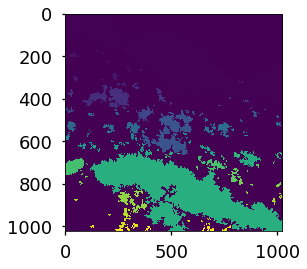

In [4]:
i = 2
fn = "/mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-0/img_000000111_3_000.tif"
with Image.open(fn) as img:
#     print(f_names[i])
    _, _, im_arr = get_data_from_frame(img)
    im_arr = np.round(skimage.transform.downscale_local_mean(im_arr, (2,2)))
#     im_arr = im_arr.astype(np.float32).astype(np.uint16)
    im_arr = im_arr.astype(np.float32).astype(np.uint16) / 65535
#     im_arr[800:830,190:210]=im_arr.mean()
#     im_arr = im_arr[200:400,200:400]
#     im_arr = im_arr / im_arr.mean()
    w, h = im_arr.shape

    # Make the structuring element
    selem = skimage.morphology.square(4)
    # Perform the median filter
    im_filt = skimage.filters.median(im_arr, selem)

    # Convert the uneven image to floating point
    im_float = im_filt / 4096
    # Smooth to reduce noise
#     g_radius = 10
#     im_smooth = skimage.filters.gaussian(im_float, g_radius)
#     im_bgsub = im_float - im_smooth

    thresh_factor = 0.3
    
    # threshold
#     im_boxed = im_bgsub > thresh_factor*im_bgsub.max()

    # Adjust exposure
    im_adj = skimage.exposure.equalize_adapthist(im_filt)

    # Edge detection
#     im_edge = skimage.filters.sobel(im_adj)
    im_edge = skimage.exposure.equalize_adapthist(im_adj)
#     im_edge = skimage.filters.gaussian(im_edge, 4)

    # Remove small objects and fill holes
    thresh = skimage.filters.threshold_otsu(im_edge)
#     selem = skimage.morphology.square(1)
    im_bw = ndi.morphology.binary_fill_holes(im_edge > thresh)#, selem)
    im_bw = skimage.morphology.remove_small_objects(im_bw, min_size=50)

    im_labeled, num = skimage.morphology.label(im_bw, return_num=True)
    plt.imshow(im_labeled)
    print(im_arr.dtype)
    print(num)

titles = ("im_arr", "im_filt", "im_bgsub", "im_adj", "im_edge", "im_bw", "im_labeled>0")
plots = (im_arr>(200/65535), im_filt, im_bgsub, im_adj, im_edge>thresh, im_bw, im_labeled>0)
for im, title in zip(plots, titles):
    plt.figure(figsize=(7,7))
    plt.imshow(im)
    plt.title(title)

plt.figure()
_ = plt.hist(im_edge.flatten(), bins=200)

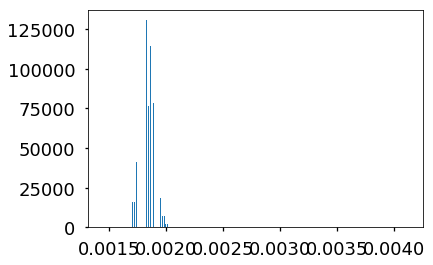

In [21]:
_ = plt.hist(im_arr.flatten(), bins=500)
# _ = plt.imshow(skimage.filters.gaussian(im_arr, 2) > (130/65535))

In [97]:
# Scrape metadata

top_folder = "/mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1"
img_dirs = np.sort([os.path.join(top_folder,x) for x in os.listdir(top_folder) if os.path.isdir(os.path.join(top_folder,x))])
f_names = [os.path.join(img_dir, fn) for img_dir in img_dirs for fn in os.listdir(img_dir) if '.tif' in fn[-4:] if 'convert' not in fn]
# p3_names = [f_n for f_n in f_names if "Pos3" in f_n]

# concat_img_files(f_names[::40], 'test_out.tif')

def make_tdf():
    template = "/mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p{}-{}/img_{:09d}_0_000.tif"
    metadata = dict(zip(keep_keys, keep_keys))
    i = 0
    t_skip = 1
    t_points = np.arange(0,142,t_skip)
    t_len = len(t_points)
    c_points = [0,3,5]
    p_skip = 1
    p_points = np.arange(0,9,p_skip)
    p_len = len(p_points)
    t_df = pd.DataFrame(np.empty((142*9,3)), columns=['frame', 'pos', 'time'])
    for p_i in p_points:
        for t_i in t_points:
            pad_i = p_i // 3
            loc_i = np.mod(p_i, 3)
            fn_out = save_tmp.format(p_i, t_i)
            fn = template.format(pad_i, loc_i, t_i)
            t_df.loc[i,:] = np.array([t_i, p_i, ctime(fn)])
            i += 1
    t_df.to_csv('180509_time.csv', index=False)


# make_tdf()
t_df = pd.read_csv('180509_time.csv')

In [29]:
top_folder = "/mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1"
img_dirs = np.sort([os.path.join(top_folder,x) for x in os.listdir(top_folder) if os.path.isdir(os.path.join(top_folder,x))])
f_names = [os.path.join(img_dir, fn) for img_dir in img_dirs for fn in os.listdir(img_dir) if '.tif' in fn[-4:] if 'convert' not in fn]
# p3_names = [f_n for f_n in f_names if "Pos3" in f_n]

# concat_img_files(f_names[::40], 'test_out.tif')

def make_movie(fn_list, fn_out):
    template = "/mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p{}-{}/img_{:09d}_{:d}_000.tif"
    keep_keys = ['Channel', 'Time', 'PositionName']
    metadata = dict(zip(keep_keys, keep_keys))
    i = 0
    #ct = datetime.datetime.fromtimestamp(ctime(fn))
    t_skip = 1
    t_points = np.arange(0,142,t_skip)
    t_len = len(t_points)
    c_points = [0,3,5]
    p_skip = 1
    p_points = np.arange(0,9,p_skip)
    p_len = len(p_points)
    im_out = np.zeros((t_len,p_len,4,2048//2,2048//2,1), dtype=np.uint16)
    with TiffWriter(fn_out, imagej=True, append=False) as tif:
        for tp in t_points:
            for pp in p_points:
                pad_i = pp // 3
                loc_i = np.mod(pp, 3)
                for cp in c_points:
                    fn = template.format(pad_i, loc_i, tp, cp)
                    eof_flag = True
                    print("Writing ", fn)
                    with Image.open(fn) as img:
                        while eof_flag:
                            _, _, im_arr = get_data_from_frame(img)
                            im_arr = np.round(skimage.transform.downscale_local_mean(im_arr, (2,2)))
                            im_arr = im_arr.astype(np.float32).astype(np.uint16)
                            img_md = img_metadata_dict(img)
                            for k in keep_keys:
                                metadata[k] = img_md[k]
                            h, w = im_arr.shape
                            im_out[tp//t_skip, pp//p_skip, cp//2, :, :, 0] = im_arr
                            try:
                                i += 1
                                img.seek(img.tell()+1)
                            except:
                                eof_flag = False
                lab, num = label_image(im_out[tp//t_skip, pp//p_skip, 0, :, :, 0])
                im_out[tp//t_skip, pp//p_skip, 3, :, :, 0] = lab.astype(np.uint16)
        tif.save(im_out, metadata=metadata.copy())

make_movie(f_names, '180509_fullmovie_masktry.tif')

Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-0/img_000000000_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-0/img_000000000_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-0/img_000000000_5_000.tif


/home/jmp/miniconda2/envs/ipykernel_py3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/jmp/miniconda2/envs/ipykernel_py3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-1/img_000000000_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-1/img_000000000_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-1/img_000000000_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-2/img_000000000_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-2/img_000000000_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-2/img_000000000_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-0/img_000000000_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-0/img_000000000_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-0/img_000000000_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/

Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-0/img_000000003_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-0/img_000000003_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-1/img_000000003_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-1/img_000000003_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-1/img_000000003_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-2/img_000000003_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-2/img_000000003_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-2/img_000000003_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-0/img_000000003_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/

Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-2/img_000000005_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-0/img_000000006_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-0/img_000000006_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-0/img_000000006_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-1/img_000000006_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-1/img_000000006_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-1/img_000000006_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-2/img_000000006_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-2/img_000000006_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/

Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-2/img_000000008_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-2/img_000000008_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-2/img_000000008_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-0/img_000000009_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-0/img_000000009_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-0/img_000000009_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-1/img_000000009_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-1/img_000000009_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-1/img_000000009_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/

Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-1/img_000000011_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-1/img_000000011_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-2/img_000000011_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-2/img_000000011_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-2/img_000000011_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-0/img_000000012_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-0/img_000000012_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-0/img_000000012_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-1/img_000000012_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/

Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-0/img_000000014_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-1/img_000000014_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-1/img_000000014_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-1/img_000000014_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-2/img_000000014_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-2/img_000000014_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-2/img_000000014_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-0/img_000000015_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-0/img_000000015_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/

Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-0/img_000000017_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-0/img_000000017_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-0/img_000000017_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-1/img_000000017_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-1/img_000000017_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-1/img_000000017_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-2/img_000000017_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-2/img_000000017_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-2/img_000000017_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/

Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-2/img_000000020_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-2/img_000000020_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-0/img_000000020_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-0/img_000000020_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-0/img_000000020_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-1/img_000000020_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-1/img_000000020_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-1/img_000000020_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-2/img_000000020_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/

Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-1/img_000000023_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-2/img_000000023_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-2/img_000000023_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-2/img_000000023_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-0/img_000000023_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-0/img_000000023_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-0/img_000000023_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-1/img_000000023_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-1/img_000000023_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/

Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-1/img_000000026_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-1/img_000000026_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-1/img_000000026_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-2/img_000000026_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-2/img_000000026_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-2/img_000000026_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-0/img_000000026_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-0/img_000000026_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-0/img_000000026_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/

Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-0/img_000000029_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-0/img_000000029_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-1/img_000000029_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-1/img_000000029_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-1/img_000000029_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-2/img_000000029_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-2/img_000000029_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-2/img_000000029_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-0/img_000000029_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/

Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-2/img_000000032_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-0/img_000000032_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-0/img_000000032_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-0/img_000000032_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-1/img_000000032_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-1/img_000000032_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-1/img_000000032_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-2/img_000000032_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-2/img_000000032_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/

Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-2/img_000000035_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-2/img_000000035_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-2/img_000000035_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-0/img_000000035_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-0/img_000000035_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-0/img_000000035_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-1/img_000000035_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-1/img_000000035_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-1/img_000000035_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/

Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-1/img_000000038_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-1/img_000000038_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-2/img_000000038_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-2/img_000000038_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-2/img_000000038_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-0/img_000000038_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-0/img_000000038_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-0/img_000000038_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-1/img_000000038_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/

Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-0/img_000000041_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-1/img_000000041_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-1/img_000000041_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-1/img_000000041_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-2/img_000000041_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-2/img_000000041_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-2/img_000000041_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-0/img_000000041_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-0/img_000000041_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/

Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-0/img_000000044_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-0/img_000000044_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-0/img_000000044_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-1/img_000000044_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-1/img_000000044_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-1/img_000000044_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-2/img_000000044_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-2/img_000000044_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-2/img_000000044_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/

Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-2/img_000000046_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-2/img_000000046_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-0/img_000000047_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-0/img_000000047_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-0/img_000000047_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-1/img_000000047_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-1/img_000000047_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-1/img_000000047_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-2/img_000000047_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/

Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-1/img_000000049_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-2/img_000000049_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-2/img_000000049_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-2/img_000000049_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-0/img_000000050_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-0/img_000000050_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-0/img_000000050_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-1/img_000000050_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-1/img_000000050_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/

Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-1/img_000000052_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-1/img_000000052_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-1/img_000000052_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-2/img_000000052_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-2/img_000000052_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-2/img_000000052_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-0/img_000000053_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-0/img_000000053_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-0/img_000000053_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/

Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-0/img_000000055_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-0/img_000000055_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-1/img_000000055_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-1/img_000000055_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-1/img_000000055_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-2/img_000000055_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-2/img_000000055_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-2/img_000000055_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-0/img_000000056_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/

Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-2/img_000000058_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-0/img_000000058_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-0/img_000000058_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-0/img_000000058_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-1/img_000000058_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-1/img_000000058_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-1/img_000000058_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-2/img_000000058_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-2/img_000000058_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/

Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-2/img_000000061_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-2/img_000000061_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-2/img_000000061_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-0/img_000000061_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-0/img_000000061_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-0/img_000000061_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-1/img_000000061_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-1/img_000000061_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-1/img_000000061_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/

Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-1/img_000000064_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-1/img_000000064_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-2/img_000000064_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-2/img_000000064_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-2/img_000000064_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-0/img_000000064_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-0/img_000000064_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-0/img_000000064_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-1/img_000000064_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/

Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-0/img_000000067_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-1/img_000000067_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-1/img_000000067_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-1/img_000000067_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-2/img_000000067_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-2/img_000000067_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-2/img_000000067_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-0/img_000000067_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-0/img_000000067_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/

Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-0/img_000000070_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-0/img_000000070_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-0/img_000000070_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-1/img_000000070_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-1/img_000000070_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-1/img_000000070_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-2/img_000000070_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-2/img_000000070_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-2/img_000000070_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/

Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-2/img_000000073_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-2/img_000000073_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-0/img_000000073_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-0/img_000000073_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-0/img_000000073_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-1/img_000000073_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-1/img_000000073_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-1/img_000000073_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-2/img_000000073_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/

Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-1/img_000000076_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-2/img_000000076_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-2/img_000000076_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-2/img_000000076_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-0/img_000000076_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-0/img_000000076_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-0/img_000000076_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-1/img_000000076_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-1/img_000000076_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/

Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-1/img_000000079_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-1/img_000000079_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-1/img_000000079_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-2/img_000000079_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-2/img_000000079_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-2/img_000000079_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-0/img_000000079_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-0/img_000000079_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-0/img_000000079_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/

Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-0/img_000000082_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-0/img_000000082_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-1/img_000000082_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-1/img_000000082_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-1/img_000000082_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-2/img_000000082_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-2/img_000000082_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-2/img_000000082_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-0/img_000000082_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/

Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-2/img_000000084_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-0/img_000000085_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-0/img_000000085_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-0/img_000000085_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-1/img_000000085_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-1/img_000000085_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-1/img_000000085_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-2/img_000000085_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-2/img_000000085_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/

Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-2/img_000000087_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-2/img_000000087_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-2/img_000000087_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-0/img_000000088_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-0/img_000000088_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-0/img_000000088_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-1/img_000000088_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-1/img_000000088_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-1/img_000000088_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/

Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-1/img_000000090_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-1/img_000000090_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-2/img_000000090_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-2/img_000000090_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-2/img_000000090_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-0/img_000000091_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-0/img_000000091_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-0/img_000000091_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-1/img_000000091_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/

Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-0/img_000000093_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-1/img_000000093_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-1/img_000000093_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-1/img_000000093_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-2/img_000000093_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-2/img_000000093_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-2/img_000000093_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-0/img_000000094_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-0/img_000000094_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/

Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-0/img_000000096_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-0/img_000000096_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-0/img_000000096_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-1/img_000000096_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-1/img_000000096_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-1/img_000000096_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-2/img_000000096_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-2/img_000000096_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-2/img_000000096_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/

Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-2/img_000000099_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-2/img_000000099_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-0/img_000000099_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-0/img_000000099_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-0/img_000000099_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-1/img_000000099_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-1/img_000000099_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-1/img_000000099_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-2/img_000000099_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/

Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-1/img_000000102_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-2/img_000000102_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-2/img_000000102_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-2/img_000000102_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-0/img_000000102_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-0/img_000000102_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-0/img_000000102_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-1/img_000000102_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-1/img_000000102_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/

Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-1/img_000000105_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-1/img_000000105_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-1/img_000000105_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-2/img_000000105_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-2/img_000000105_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-2/img_000000105_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-0/img_000000105_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-0/img_000000105_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-0/img_000000105_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/

Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-0/img_000000108_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-0/img_000000108_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-1/img_000000108_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-1/img_000000108_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-1/img_000000108_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-2/img_000000108_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-2/img_000000108_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-2/img_000000108_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-0/img_000000108_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/

Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-2/img_000000111_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-0/img_000000111_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-0/img_000000111_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-0/img_000000111_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-1/img_000000111_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-1/img_000000111_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-1/img_000000111_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-2/img_000000111_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-2/img_000000111_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/

Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-2/img_000000114_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-2/img_000000114_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-2/img_000000114_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-0/img_000000114_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-0/img_000000114_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-0/img_000000114_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-1/img_000000114_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-1/img_000000114_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-1/img_000000114_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/

Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-1/img_000000117_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-1/img_000000117_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-2/img_000000117_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-2/img_000000117_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-2/img_000000117_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-0/img_000000117_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-0/img_000000117_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-0/img_000000117_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-1/img_000000117_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/

Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-0/img_000000120_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-1/img_000000120_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-1/img_000000120_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-1/img_000000120_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-2/img_000000120_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-2/img_000000120_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-2/img_000000120_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-0/img_000000120_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-0/img_000000120_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/

Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-0/img_000000123_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-0/img_000000123_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-0/img_000000123_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-1/img_000000123_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-1/img_000000123_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-1/img_000000123_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-2/img_000000123_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-2/img_000000123_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-2/img_000000123_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/

Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-2/img_000000125_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-2/img_000000125_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-0/img_000000126_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-0/img_000000126_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-0/img_000000126_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-1/img_000000126_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-1/img_000000126_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-1/img_000000126_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-2/img_000000126_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/

Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-1/img_000000128_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-2/img_000000128_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-2/img_000000128_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-2/img_000000128_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-0/img_000000129_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-0/img_000000129_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-0/img_000000129_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-1/img_000000129_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-1/img_000000129_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/

Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-1/img_000000131_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-1/img_000000131_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-1/img_000000131_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-2/img_000000131_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-2/img_000000131_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-2/img_000000131_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-0/img_000000132_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-0/img_000000132_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-0/img_000000132_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/

Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-0/img_000000134_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-0/img_000000134_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-1/img_000000134_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-1/img_000000134_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-1/img_000000134_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-2/img_000000134_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-2/img_000000134_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-2/img_000000134_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p0-0/img_000000135_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/

Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-2/img_000000137_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-0/img_000000137_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-0/img_000000137_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-0/img_000000137_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-1/img_000000137_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-1/img_000000137_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-1/img_000000137_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-2/img_000000137_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-2/img_000000137_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/

Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-2/img_000000140_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-2/img_000000140_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p1-2/img_000000140_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-0/img_000000140_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-0/img_000000140_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-0/img_000000140_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-1/img_000000140_0_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-1/img_000000140_3_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1/p2-1/img_000000140_5_000.tif
Writing  /mnt/disks/timelapse-movies/20180509_three_fc_variants/

/home/jmp/miniconda2/envs/ipykernel_py3/lib/python3.6/site-packages/skimage/external/tifffile/tifffile.py:1088: UserWarning: truncating ImageJ file
  warnings.warn("truncating ImageJ file")


In [ ]:
x=40
dif = 0
def filt(img):
#     selem = skimage.morphology.square(1)
#     # Perform the median filter
#     return skimage.filters.median(img, selem)
    return skimage.filters.gaussian_filter(img, 10)

plt.figure(figsize=(10,10))
# plt.imshow(filt(im_all[x,2,0,:,:]/(2**16))-filt(im_all[x-dif,2,0,:,:]/(2**16)))
plt.imshow(im_all[x,2,0,:,:]/(2**16)-filt(im_all[x-dif,2,0,:,:]/(2**16)))
plt.figure(figsize=(10,10))
plt.imshow(im_all[x,2,0,:,:])


plt.figure(figsize=(10,10))
# plt.imshow(filt(im_all[x,2,0,:,:]/(2**16))-filt(im_all[x-dif,2,0,:,:]/(2**16)))
plt.imshow(label_image(im_all[x,2,0,:,:]/(2**16)-filt(im_all[x-dif,2,0,:,:]/(2**16)))[0])


In [ ]:
import matplotlib.animation as anm
from IPython.display import HTML

# img = skimage.io.imread(f_names[2])
def write_movie(img, skip=10, pos=3):
    plt.close('all')
    
    t_points, s, c, h, w = img.shape
    t_vec = np.arange(0, t_points, skip)
    frames = len(t_vec)
    #t_list = list(t_vec[-1::-1]) + [-1]
    
    t_list = np.arange(t_points)
    
    blank_array = np.zeros([h, w])
    fig, axs = plt.subplots(2,2, figsize=(10,8))
    im_list = [0,0,0,0]
    
    # initialize plots
    titles = ['bf', 'mscarlet', 'sfcfp', 'lab']
    vmaxs = [2.8e4  , 5e2, 4e2, 1]
    vmins = [1e4, 1e2, 1e2, 0]
    for i in np.arange(4):
        ax = axs[i//2, np.mod(i,2)]
        indxs = [i]
        vmax = vmaxs[i]
        vmin = vmins[i]
        im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none')
        cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(titles[i])
        im_list[i] = im
    
    fig.tight_layout()
    
    # animation function.  This is called sequentially
    frame_arr = np.zeros((h,w))
    def animate(i):
        # Plot 
        for j in np.arange(4):
            ax = axs[j//2, np.mod(j,2)]
            frame_arr = img[i*skip,pos,j,:,:]#.sum(axis=0)
            im_list[j].set_array(frame_arr)

    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = anm.FuncAnimation(fig, animate, interval=100, frames=frames)


    # Set up formatting for the movie files
    #Writer = anm.writers['ffmpeg_file']
    #writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=900, extra_args=['-vcodec', 'libx264'])

    # save the animation as an mp4.  This requires ffmpeg or mencoder to be
    # installed.  The extra_args ensure that the x264 codec is used, so that
    # the video can be embedded in html5.  You may need to adjust this for
    # your system: for more information, see
    # http://matplotlib.sourceforge.net/api/animation_api.html
    #anim.save('animation_{}.mp4'.format(fn), extra_args=['-vcodec', 'libx264'], dpi=50, writer=writer)
    #plt.close('all')


    #anim.save('animation_{}.mp4'.format(fn), writer=writer)
    plt.close('all')
    return anim
    #HTML(anim.to_html5_video())
    

# with skimage.external.tifffile.TiffFile('180320_fullmovie_masktry.tif') as img:
#     im_all = img.asarray()
anim = write_movie(im_all, skip=1, pos=0)
HTML(anim.to_html5_video())

In [ ]:
# anim = write_movie(im_all, skip=1, pos=4)
# HTML(anim.to_html5_video())

In [98]:
t_df

,frame,pos,time
0,0.0,0.0,1.525881e+09
1,0.0,1.0,1.525881e+09
2,0.0,2.0,1.525881e+09
3,0.0,3.0,1.525881e+09
4,0.0,4.0,1.525881e+09
5,0.0,5.0,1.525881e+09
6,0.0,6.0,1.525881e+09
7,0.0,7.0,1.525881e+09
8,0.0,8.0,1.525881e+09
9,1.0,0.0,1.525881e+09


In [ ]:
im_all[80,5,2,:,:].min()

In [ ]:
t, s, c, h, w = im_all.shape
im_out = np.zeros((t,3,h,5*w), dtype=np.float32)

# First set up the figure, the axis, and the plot element we want to animate
blank_array = np.zeros([h, 5*w, 3])
gray_array = np.ones([h, w, 3])
red_array = np.zeros([h, w, 3])
red_array[:,:,0] = np.ones([h, w])
red_array[:,:,1] = np.ones([h, w]) * 0
red_array[:,:,2] = np.ones([h, w]) * 0.
cyan_array = np.zeros([h, w, 3])
cyan_array[:,:,0] = np.ones([h, w]) * 0
cyan_array[:,:,1] = np.ones([h, w]) 
cyan_array[:,:,2] = np.ones([h, w])
i=70
# Plot cell densities
min_v = [10e3, 100, 100]
max_v = [30e3, 500, 500]
plt.figure(figsize=(15,3))
# Plot cell densities
frame = np.zeros([h, 5*w, 3])
for c, c_array in enumerate([gray_array, red_array, cyan_array]):
    for p, p_i in enumerate([5,4,3]):
        d_arr = (im_all[i,p_i,c,:,:] - min_v[c]) / (max_v[c] - min_v[c])
#         d_arr[d_arr > 1 ] = 1
#         d_arr[d_arr < 0 ] = 0
        frame[:,(2*w*p):(2*w*(1+p)-w),:] += c_array * np.stack(3*[d_arr], axis=2)
frame[frame > 1 ] = 1
frame[frame < 0 ] = 0
plt.imshow(frame)


In [103]:
#
#  Use masks to track fluorescence of microcolonies
#

import matplotlib.animation as anm
from IPython.display import HTML

# with skimage.external.tifffile.TiffFile('180509_fullmovie_masktry.tif') as img:
# #     print(img.info())
# #     img?
#     im_all = img.asarray()#memmap=True)

def par_worker(im_arr, t_df, fn_out):
    column_names = ('time', 'pos', 'colony', 'sfcfp', 'mscarlet', 'col_size', 'sfcfp_bg', 'mscarlet_bg')
    df = pd.DataFrame(columns=column_names)
    t, s, _, h, w = im_arr.shape
    for t_i in range(0,t,1):
        for s_i in range(s):
            ct = t_df.loc[(t_df.pos == s_i)&(t_df.frame == t_i), 'time'].values
            rfps, gfps, sizes, num, gfp_bg, rfp_bg = get_fluors(im_arr[t_i,s_i,1,:,:], 
                                                                im_arr[t_i,s_i,2,:,:], 
                                                                im_arr[t_i,s_i,3,:,:])
            for col_i in range(num):
                df_dict = dict(zip(column_names, [[ct], [s_i], [col_i], [gfps[col_i]], [rfps[col_i]], [sizes[col_i]], [gfp_bg], [rfp_bg]]))
                df = df.append(pd.DataFrame(df_dict), ignore_index=True)
    df.to_csv(fn_out)
    print("wrote ", fn_out)

fn_temp = "processed_part_masktry_{}.csv"
fn_outs = [fn_temp.format(i) for i in range(4)]

jobs = []
for i in [0,1,2,3]:
    p = multiprocessing.Process(target=par_worker, 
                                args=(im_all[i:8:4,:,:,:,:], 
                                t_df.copy(), fn_outs[i]))
    jobs.append(p)
    p.start()
for j in jobs:
    j.join()
print("Done!")

wrote  processed_part_masktry_1.csv
wrote  processed_part_masktry_0.csv
wrote  processed_part_masktry_2.csv
wrote  processed_part_masktry_3.csv
Done!


In [143]:
#
# Simply take means of the full field of view
#

def par_worker(im_arr, t_vec, fn_out):
    column_names = ('time', 'pos', 'sfcfp', 'mscarlet')
    df = pd.DataFrame(columns=column_names)
    t, s, _, h, w = im_arr.shape
    for t_i in range(0,t,1):
        for s_i in range(s):
            ct = t_vec[t_i]
            df_dict = dict(zip(column_names, [[ct], [s_i], [im_arr[t_i,s_i,2,:,:].mean()], [im_arr[t_i,s_i,1,:,:].mean()]]))
            df = df.append(pd.DataFrame(df_dict), ignore_index=True)
    df.to_csv(fn_out)
    print("wrote ", fn_out)

# t_df = pd.read_csv('time.csv', index_col=None)
t_piv = t_df.pivot('frame', 'pos', 'time')
fn_temp = "full_image_part_2_{}.csv"
fn_outs = [fn_temp.format(i) for i in range(4)]

jobs = []
for i in [0,1,2,3]:
    p = multiprocessing.Process(target=par_worker, 
                                args=(im_all[i::4,:,:,:,:], 
                                t_piv.values[i::4,0], fn_outs[i]))
    jobs.append(p)
    p.start()
for j in jobs:
    j.join()
print("Done!")

wrote  full_image_part_2_0.csv
wrote  full_image_part_2_1.csv
wrote  full_image_part_2_2.csv
wrote  full_image_part_2_3.csv
Done!


In [142]:
t_df.pivot('frame', 'pos', 'time').loc[:,0.0]

frame
0.0      1.525881e+09
1.0      1.525881e+09
2.0      1.525881e+09
3.0      1.525881e+09
4.0      1.525882e+09
5.0      1.525882e+09
6.0      1.525882e+09
7.0      1.525883e+09
8.0      1.525883e+09
9.0      1.525883e+09
10.0     1.525883e+09
11.0     1.525884e+09
12.0     1.525884e+09
13.0     1.525884e+09
14.0     1.525885e+09
15.0     1.525885e+09
16.0     1.525885e+09
17.0     1.525886e+09
18.0     1.525886e+09
19.0     1.525886e+09
20.0     1.525886e+09
21.0     1.525887e+09
22.0     1.525887e+09
23.0     1.525887e+09
24.0     1.525888e+09
25.0     1.525888e+09
26.0     1.525888e+09
27.0     1.525889e+09
28.0     1.525889e+09
29.0     1.525889e+09
             ...     
112.0    1.525914e+09
113.0    1.525914e+09
114.0    1.525915e+09
115.0    1.525915e+09
116.0    1.525915e+09
117.0    1.525916e+09
118.0    1.525916e+09
119.0    1.525916e+09
120.0    1.525916e+09
121.0    1.525917e+09
122.0    1.525917e+09
123.0    1.525917e+09
124.0    1.525918e+09
125.0    1.525918e+09
126.

TypeError: must be str, not int

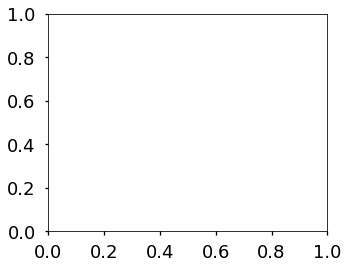

In [104]:
temp = 'processed_part_masktry_{}.csv'
column_names = ('time', 'pos', 'colony', 'sfcfp', 'mscarlet', 'col_size', 'sfcfp_bg', 'mscarlet_bg')
df = pd.DataFrame(columns=column_names)
for fn in [temp.format(i) for i in range(4)]:
    df = df.append(pd.read_csv(fn), ignore_index=True)
fig, ax = plt.subplots(1,1,figsize=(5,4))
t_min = df.time.min()
ind = (df.pos == 4) & (df.colony>15) & (df.colony<20) & (df.time < (t_min + 3*60*60)) # & (np.mod(df.colony,  5)==0 )
df_tmp = df.loc[ind,:]
# ax.plot((df_tmp.time - t_min)/3600, df_tmp.mscarlet,'r.')
# ax.plot((df_tmp.time - t_min)/3600, df_tmp.sfcfp,'c.')
ax.scatter(x=(df_tmp.time - t_min)/3600, 
           y=df_tmp.col_size,
           alpha=1, cmap='viridis')
new_t_vec = np.sort(np.unique(df_tmp.time - t_min))
r_c = (7e-3)/60
for i in np.arange(50,210,50):
    ax.plot(new_t_vec/3600, i*np.exp(new_t_vec*r_c),'k-')
# ax.set_facecolor('gray')
ax.set_ylim([-1e1,600])
ax.set_yticks(np.arange(0,601,200))
ax.set_ylabel('Colony area (pixels)')
ax.set_xlabel('Time (hours)')
ax.set_xticks(np.arange(0,4,1))
fig.tight_layout()
fig.savefig("microscope_cellgrowth.png", dpi=150, transparent=True)
fig.savefig("microscope_cellgrowth.pdf")
# fig, ax = plt.subplots(1,1,figsize=(9,9))
# # ind = (df.time < (6*60*60 + t_min)) & (df.pos == 3)
# # df_tmp = df.loc[ind,:]
to_full_screen = np.log((1024**2)/67057)/r_c
print(to_full_screen / 3600)
print((df.time.max() - t_min)/3600)
print(df.loc[(df.time == t_min)&(df.pos == 4), 'col_size'].sum())
print((df.loc[(df.time == t_min)&(df.pos == 4), 'col_size'].sum())/(1024**2))
# ax.scatter(x=df_tmp.mscarlet, 
#            y=df_tmp.sfcfp,
#            c=df_tmp.time,alpha=0.3, cmap='viridis')
# ax.set_facecolor('gray')
# (df_tmp.time[df_tmp.sfcfp > 200].min() - df_tmp.time[df_tmp.mscarlet > 200].min())


6.54677459103961
11.675277777777778
67057
0.0639505386352539


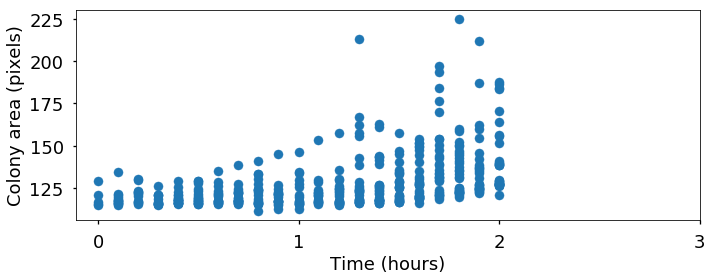

In [55]:
temp = 'processed_part_masktry_{}.csv'
column_names = ('time', 'pos', 'colony', 'sfcfp', 'mscarlet', 'col_size', 'sfcfp_bg', 'mscarlet_bg')
df = pd.DataFrame(columns=column_names)
for fn in [temp.format(i) for i in range(4)]:
    df = df.append(pd.read_csv(fn), ignore_index=True)
fig, ax = plt.subplots(1,1,figsize=(10,4))
t_min = df.time.min()
ind = (df.pos == 3) & (df.col_size>100) & (np.mod(df.colony.values,10)==0) & (df.time < (t_min + 2*60*60)) # & (np.mod(df.colony,  5)==0 )
df_tmp = df.loc[ind,:]
# ax.plot((df_tmp.time - t_min)/3600, df_tmp.mscarlet,'r.')
# ax.plot((df_tmp.time - t_min)/3600, df_tmp.sfcfp,'c.')
ax.scatter(x=(df_tmp.time - t_min)/3600, 
           y=df_tmp.mscarlet,# / df_tmp.col_size,
           alpha=1, cmap='viridis')
new_t_vec = np.sort(np.unique(df_tmp.time - t_min))
r_c = (7e-3)/60
# for i in np.arange(50,210,50):
#     ax.plot(new_t_vec/3600, i*np.exp(new_t_vec*r_c),'k-')
# ax.set_facecolor('gray')
# ax.set_ylim([-1e1,600])
# ax.set_yticks(np.arange(0,601,200))
ax.set_ylabel('Colony area (pixels)')
ax.set_xlabel('Time (hours)')
ax.set_xticks(np.arange(0,4,1))
fig.tight_layout()
# fig.savefig("microscope_cellgrowth.png", dpi=150, transparent=True)
# fig.savefig("microscope_cellgrowth.pdf")
# fig, ax = plt.subplots(1,1,figsize=(9,9))
# # ind = (df.time < (6*60*60 + t_min)) & (df.pos == 3)
# # df_tmp = df.loc[ind,:]
to_full_screen = np.log((1024**2)/67057)/r_c
print(to_full_screen / 3600)
print((df.time.max() - t_min)/3600)
print(df.loc[(df.time == t_min)&(df.pos == 4), 'col_size'].sum())
print((df.loc[(df.time == t_min)&(df.pos == 4), 'col_size'].sum())/(1024**2))
# ax.scatter(x=df_tmp.mscarlet, 
#            y=df_tmp.sfcfp,
#            c=df_tmp.time,alpha=0.3, cmap='viridis')
# ax.set_facecolor('gray')
# (df_tmp.time[df_tmp.sfcfp > 200].min() - df_tmp.time[df_tmp.mscarlet > 200].min())


In [160]:
np.sqrt(np.sum(np.power(cor_pos_df.loc[np.arange(3),['x', 'y']],2).values,axis=1))

array([ 3760.02583236,  7061.39429929, 11514.91396277])

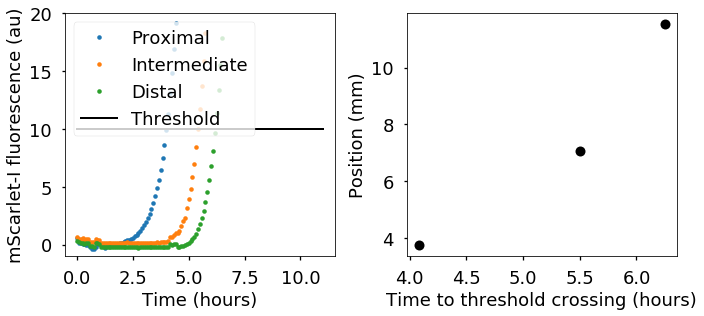

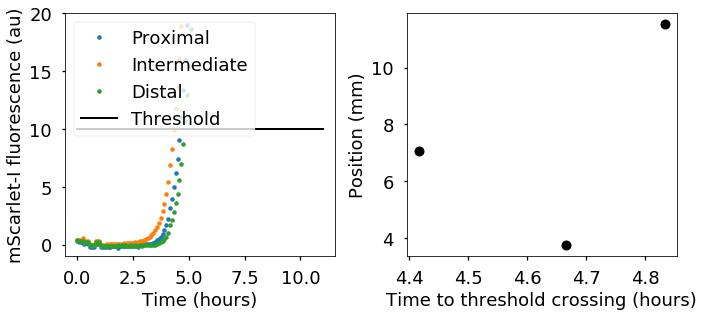

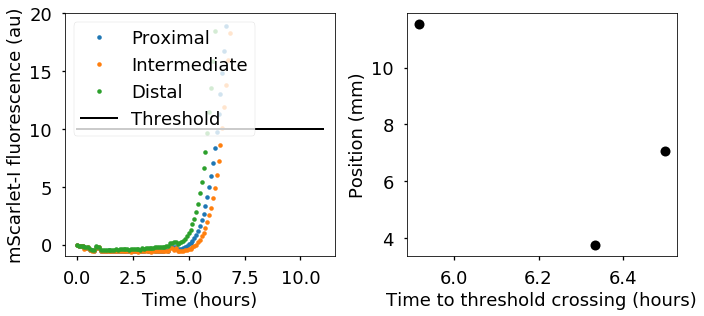

In [181]:
temp = 'full_image_part_2_{}.csv'
column_names = ('time', 'pos', 'sfcfp', 'mscarlet')
df = pd.DataFrame(columns=column_names)
df.pos = df.pos.astype(np.float)
for fn in [temp.format(i) for i in range(4)]:
    df = df.append(pd.read_csv(fn, index_col=0), ignore_index=True)
    
t_min = df.time.min()

def plot_positions(df, pos_list, title, labels, channel, chan_lab):
    fig, axs = plt.subplots(1,2, figsize=(10,4.5))
    df = df.sort_values('time')
    n = len(pos_list)
#     for c_i, channel in enumerate(["mscarlet", "sfcfp"]):
    tim_inds = ((df.time - t_min)/3600) < 11
    df_bg = df.loc[((df.time - t_min)/3600) < 1&(df.pos==0),channel]
    bg = df_bg.mean()
    pos_inds = np.sum([df.pos == xx for xx in pos_list],axis=0) > 0
    df_sub = df.loc[pos_inds & tim_inds,:]
    df_piv = df_sub.pivot('pos', 'time', channel)
    t_vec = df_piv.columns.values
    t_vec_corr = (t_vec - t_min)/3600
    arr = df_piv.values - bg
    thresh = 10
    arr_thresh = arr > thresh
    t_cross = np.zeros(n) * np.nan
    for i in np.arange(n):
        t_thresh = t_vec[arr_thresh[i,:]]
        if len(t_thresh) > 0:
            t_cross[i] = t_thresh.min()
#     x_vec = positions_list[pos_list.astype(int),:]
    x_vec = np.sqrt(np.sum(np.power(cor_pos_df.loc[np.arange(3),['x', 'y']],2).values,axis=1))/1000
    cross_vec = (t_cross - t_min)/3600
    axs[1].plot(cross_vec, x_vec, 'ko', ms=10)
    n_cross = np.sum(1 - np.isnan(t_cross))
#     if n_cross > 1:
#         interp_x = np.linspace(t_vec_corr[0], t_vec_corr[-1],100)
#         f_interp = scp.interpolate.interp1d(cross_vec[:n_cross], x_vec[:n_cross], 
#                                             kind='linear', fill_value='extrapolate')
#         interp_y = f_interp(interp_x)
#         axs[1].plot(interp_x, interp_y, '-')
#     if np.isnan(t_cross).sum() < 2 : 
#         nan_inds = np.isnan(t_cross)
#         cv = cross_vec[(1-nan_inds)>0]
#         xv = x_vec[(1-nan_inds)>0]
#         slope = np.diff(xv) / np.diff(cv)
#         print(slope)
#         axs[1].text(0.6,11,"Slope = {:0.2f} mm/hour".format(slope[0]), fontsize=16)
    axs[0].plot((t_vec - t_min) / 3600, arr.T, '.')
    axs[0].plot([t_vec_corr[0], t_vec_corr[-1]], 2*[thresh], 'k-')
    axs[0].set_ylim([-1,20])
#     axs[0].set_yticks(np.arange(0,31,10))
    axs[0].set_ylabel(chan_lab)
    axs[0].set_xlabel("Time (hours)")
#     axs[0].set_xticks(np.arange(1,11,2))
    axs[0].legend(labels=['Proximal', 'Intermediate', 'Distal','Threshold'], 
                  loc=2, frameon=True)
#     axs[1].set_xlim([t_vec_corr[0], t_vec_corr[-1]])
#     axs[1].set_ylim([-1, 4*4.5])
#     axs[1].set_yticks(x_vec)
#     axs[1].set_yticklabels(np.round(x_vec,1))
#     axs[1].set_xticks(np.arange(1,11,2))
    axs[1].set_xlabel("Time to threshold crossing (hours)")
    axs[1].set_ylabel("Position (mm)")
    plt.tight_layout()

labels = 3*["Signal source", "Near", "Far"]
plot_positions(df, np.arange(3), "Inactive senders, pulsers", labels, 'mscarlet', 'mScarlet-I fluorescence (au)')
# plt.savefig('pad1_mscarlet.pdf')
# plt.savefig('pad1_mscarlet.png', dpi=150, transparent=True)
plot_positions(df, np.arange(3,6), "Senders, pulsers", labels, 'mscarlet', 'mScarlet-I fluorescence (au)')
# plt.savefig('pad2_mscarlet.pdf')
# plt.savefig('pad2_mscarlet.png', dpi=150, transparent=True)
plot_positions(df, np.arange(6,9), "Senders, receivers", labels, 'mscarlet', 'mScarlet-I fluorescence (au)')
# plt.savefig('pad3_mscarlet.pdf')
# plt.savefig('pad3_mscarlet.png', dpi=150, transparent=True)


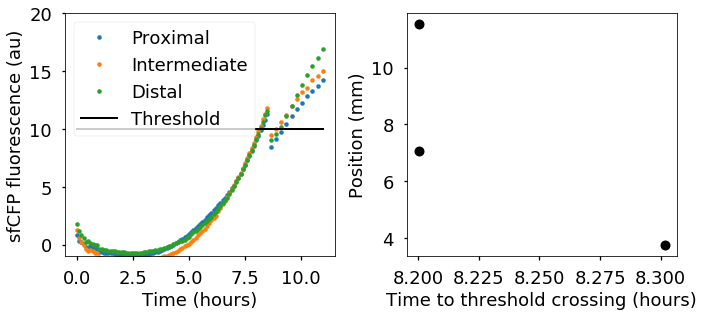

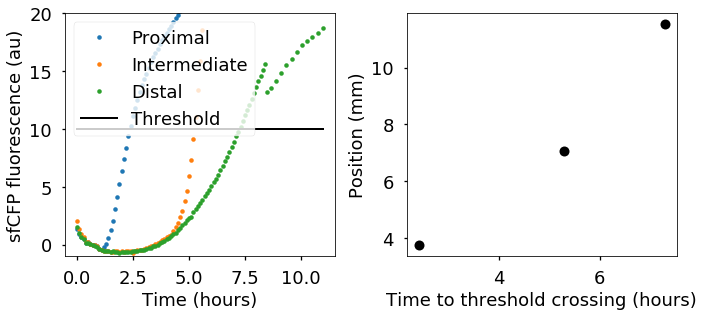

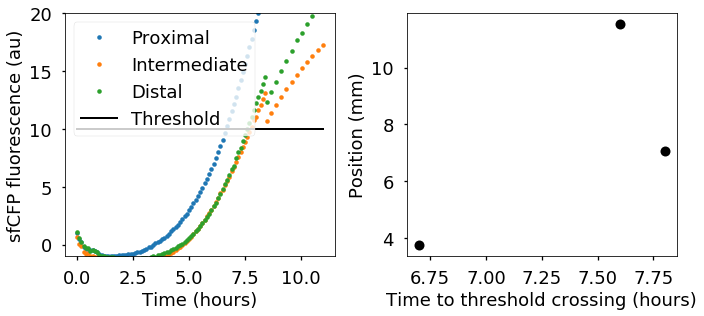

In [182]:
temp = 'full_image_part{}.csv'
column_names = ('time', 'pos', 'sfcfp', 'mscarlet')
df = pd.DataFrame(columns=column_names)
for fn in [temp.format(i) for i in range(4)]:
    df = df.append(pd.read_csv(fn, index_col=0), ignore_index=True)
    
t_min = df.time.min()

# def plot_positions(df, pos_list, title, labels, channel, chan_lab):
#     fig, axs = plt.subplots(1,2, figsize=(10,4.5))
#     df = df.sort_values('time')
#     n = len(pos_list)
# #     for c_i, channel in enumerate(["mscarlet", "sfcfp"]):
#     tim_inds = ((df.time - t_min)/3600) < 10
#     df_bg = df.loc[tim_inds&(df.pos==1),channel]
#     bg = np.tile(df_bg.values.T, (n, 1))
#     pos_inds = np.sum([df.pos == xx for xx in pos_list],axis=0) > 0
#     df_sub = df.loc[pos_inds & tim_inds,:]
#     df_piv = df_sub.pivot('pos', 'time', channel)
#     t_vec = df_piv.columns.values
#     t_vec_corr = (t_vec - t_min)/3600
#     arr = df_piv.values - bg
#     thresh = 10
#     arr_thresh = arr > thresh
#     t_cross = np.zeros(n) * np.nan
#     for i in np.arange(n):
#         t_thresh = t_vec[arr_thresh[i,:]]
#         if len(t_thresh) > 0:
#             t_cross[i] = t_thresh.min()
#     x_vec = positions_list[pos_list.astype(int),:]
#     x_vec = np.array([np.sqrt(np.power(xx - x_vec[0,:],2).sum())/1e3 for xx in x_vec])
#     cross_vec = (t_cross - t_min)/3600
#     axs[1].plot(cross_vec, x_vec, 'ko', ms=10)
#     n_cross = np.sum(1 - np.isnan(t_cross))
#     if n_cross > 1:
#         interp_x = np.linspace(t_vec_corr[0], t_vec_corr[-1],100)
#         f_interp = scp.interpolate.interp1d(cross_vec[:n_cross], x_vec[:n_cross], 
#                                             kind='linear', fill_value='extrapolate')
#         interp_y = f_interp(interp_x)
#         axs[1].plot(interp_x, interp_y, '-')
#     if np.isnan(t_cross).sum() < 2 : 
#         nan_inds = np.isnan(t_cross)
#         cv = cross_vec[(1-nan_inds)>0]
#         xv = x_vec[(1-nan_inds)>0]
#         slope = np.diff(xv) / np.diff(cv)
# #         print(slope)
#         axs[1].text(0.6,11,"Slope = {:0.2f} mm/hour".format(slope[0]), fontsize=16)
#     axs[1].set_xlim([t_vec_corr[0], t_vec_corr[-1]])
#     axs[1].set_ylim([-1, 4*4.5])
#     axs[0].plot((t_vec - t_min) / 3600, arr.T, '.')
#     axs[0].plot([t_vec_corr[0], t_vec_corr[-1]], 2*[thresh], 'k-')
#     axs[0].set_ylim([-1,20])
#     axs[0].set_yticks(np.arange(0,31,10))
#     axs[1].set_yticks(np.arange(0,17,5))
#     axs[0].set_ylabel(chan_lab)
#     axs[0].set_xlabel("Time (hours)")
#     axs[0].set_xticks(np.arange(1,7,2))
#     axs[0].legend(labels=['Proximal', 'Intermediate', 'Distal','Threshold'], 
#                   loc=2, frameon=True)
#     axs[1].set_xticks(np.arange(1,7,2))
#     axs[1].set_xlabel("Time to threshold crossing (hours)")
#     axs[1].set_ylabel("Position (mm)")
#     plt.tight_layout()

labels = 3*["Signal source", "Near", "Far"]
plot_positions(df, np.arange(3), "Inactive senders, pulsers", labels, 'sfcfp', 'sfCFP fluorescence (au)')
# plt.savefig('pad1_sfcfp.pdf')
# plt.savefig('pad1_sfcfp.png', dpi=150, transparent=True)
plot_positions(df, np.arange(3,6), "Senders, pulsers", labels, 'sfcfp', 'sfCFP fluorescence (au)')
# plt.savefig('pad2_sfcfp.pdf')
# plt.savefig('pad2_sfcfp.png', dpi=150, transparent=True)
plot_positions(df, np.arange(6,9), "Senders, receivers", labels, 'sfcfp', 'sfCFP fluorescence (au)')
# plt.savefig('pad3_sfcfp.pdf')
# plt.savefig('pad3_sfcfp.png', dpi=150, transparent=True)


(70,)


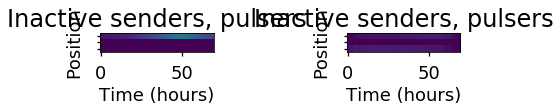

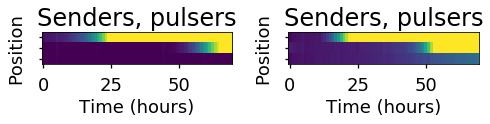

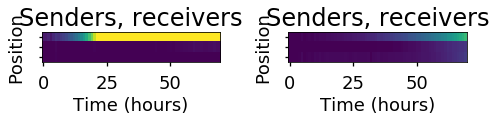

In [6]:
temp = 'full_image_part{}.csv'
column_names = ('time', 'pos', 'sfcfp', 'mscarlet')
df = pd.DataFrame(columns=column_names)
for fn in [temp.format(i) for i in range(4)]:
    df = df.append(pd.read_csv(fn), ignore_index=True)
    
t_min = df.time.min()

def plot_positions(df, pos_list, title, labels):
    fig, axs = plt.subplots(1,2, figsize=(7,4))
    for c_i, channel in enumerate(["mscarlet", "sfcfp"]):
        bg = df.loc[(df.pos==1)& (df.time < (t_min+7*3600)),channel]
        arr = np.zeros((3,bg.shape[0]))
        for i in pos_list:
            indx = (df.pos == i) & (df.time < (t_min+7*3600))
            x = (df.time[indx].values - t_min)/3600
            order_inds = np.argsort(x)
            y = df.loc[indx,channel].values - bg.values
            arr[np.mod(i,3), :] = y[order_inds]
        axs[c_i].imshow(arr, vmin=0, vmax=10)
        axs[c_i].set_title(title)
        axs[c_i].set_aspect(4)
        axs[c_i].set_xlabel("Time (hours)")
        axs[c_i].set_ylabel("Position")
        axs[c_i].set_yticks(np.arange(3))
        axs[c_i].set_yticklabels([""])
#         axs[c_i].set_ylim([-10,50])
#         axs[c_i].legend(loc=2)
    plt.tight_layout()

labels = 3*["Signal source", "Near", "Far"]
plot_positions(df, np.arange(3), "Inactive senders, pulsers", labels)
plt.savefig('pad1.pdf')
plot_positions(df, np.arange(3,6), "Senders, pulsers", labels)
plt.savefig('pad2.pdf')
plot_positions(df, np.arange(6,9), "Senders, receivers", labels)
plt.savefig('pad3.pdf')
print(df.loc[(df.pos==1)& (df.time < (t_min+7*3600)),'mscarlet'].shape)

In [3]:

2.0 * 4.5 / (3*60)

0.05

([<matplotlib.axis.XTick at 0x7f59860f47b8>,
 <a list of 9 Text xticklabel objects>)

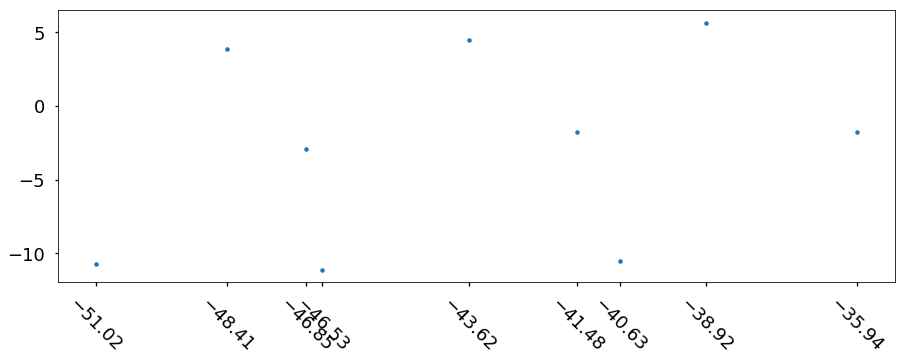

In [199]:
plt.figure(figsize=(15,5))
plt.plot(positions_list[:,0]/1e3,positions_list[:,1]/1e3,'.')
plt.xticks(positions_list[:,0]/1e3, rotation = -45)

In [200]:
np.sqrt(np.power(positions_list[3,:] - positions_list[4,:], 2).sum())/1000

5.540600000000006

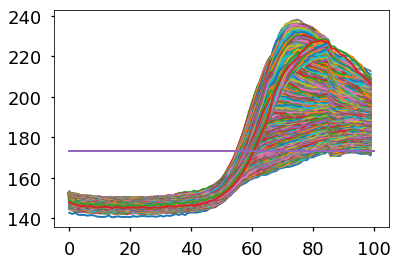

In [201]:
# plt.imshow(im_all[:,4,2,:,:].mean(axis=2), aspect=10)#, vmin=100, vmax=500)
# plt.colorbar()
mean_slice = im_all[:,4,2,:,:].mean(axis=2)
thresh = skimage.filters.threshold_otsu(mean_slice)
_ = plt.plot(im_all[:,4,2,:,:].mean(axis=2))#, aspect=10)#, vmin=100, vmax=500)
plt.plot([0,100], [thresh, thresh])

In [8]:
import scipy.optimize as opt
tvec = np.sort(np.unique(df.time.values)) / 3600.0
tvec = tvec - tvec.min()
def proc_pos_thresh(arr, tvec, c='r'):
    _, w = arr.shape
    arr = arr
    thresh = skimage.filters.threshold_li(arr) # arr[-1,:].min() #+ 10 # 250 # skimage.filters.threshold_li(arr)
    above_thresh = arr > thresh
    crossings = np.zeros(w)
    for j in np.arange(w):
        if np.any(above_thresh[:,j]):
            crossings[j] = tvec[above_thresh[:,j]].min()

    offset = np.sqrt(np.sum(np.power(positions_list[3,:]-positions_list[4,:],2)))
    xvec = np.arange(w)*(0.768/1024) + (offset/1e3)
    fit_x = xvec[crossings>0]
    fit_crossings = crossings[crossings>0]
    arr_maxes = arr.mean(axis=0)

    def f_fun(p, t=fit_crossings):
        c0,c1 = p
        return c0 + c1 * (t)

    def f_res(p, t=fit_crossings):
        c0,c1 = p
        if c1 < 0:
            return np.inf
    #     if c2 < 0:
    #         return np.inf
        res = fit_x - f_fun(p, t)
        return np.sum(res*res)

    est_slope = (fit_x[-1] - fit_x[0]) / (fit_crossings[-1] - fit_crossings[0])
    est_y_int = fit_x[0] - fit_crossings[0]*est_slope
    fit_out = opt.minimize(f_res, np.array([est_y_int, est_slope]))
    fit_p = fit_out.x
    plt.plot(fit_crossings, fit_x, c, alpha=0.5)
    plt.plot(fit_crossings, f_fun(fit_p),'k')
    plt.xlabel("Time (hours)")
    plt.ylabel("Position (mm)")
    return fit_p

plt.figure(figsize=(6,5))
tslice = slice(45, 65)
fit_r = proc_pos_thresh(im_all[tslice,4,1,:,-2:2:-1].mean(axis=1), tvec[tslice], 'r.')
plt.text(5.6, 5.45, "mscarlet = {:.3f}mm/hr".format(fit_r[1]), fontsize=16)

# plt.figure(figsize=(6,5))
fit_c  = proc_pos_thresh(im_all[tslice,4,2,:,-2:2:-1].mean(axis=1)+0.00, tvec[tslice], 'c.')
plt.text(5.09, 6.4, "sfcfp = {:.3f}mm/hr".format(fit_c[1]), fontsize=16)
plt.tight_layout()
plt.savefig('within_pos_velocity.pdf')
plt.savefig('within_pos_velocity.png', dpi=150, transparent=True)
# plt.ylim([-0.02,0.8])
# plt.xlim([5, 8])


# widths = above_thresh.sum(axis=1)
# mean_width = np.sum(widths[:-1] * np.diff(tvec)) / (tvec[-1] - tvec[0])
# fit_df.loc[i,"width"] = mean_width * (4.5/scale)
# arr_maxes = arr.max(axis=0)
# peak_vec = np.array([tvec[arr[:,i] == arr_maxes[i]][0] for i in np.arange(len(arr_maxes))])
# fit_df.loc[i, "pulse"] = np.float((len(tvec) * 0.05) > np.sum(np.diff(peak_vec) < 1))
# if len(fit_x)>0:
#     fit_df.loc[i, "mean_v"] = fit_x.max()/fit_crossings.max()
#     fit_df.loc[i, "amp"] = arr_maxes.mean()
# else:
#     fit_df.loc[i, "mean_v"] = 0
#     fit_df.loc[i, "amp"] = 0

NameError: name 'im_all' is not defined

<Figure size 432x360 with 0 Axes>

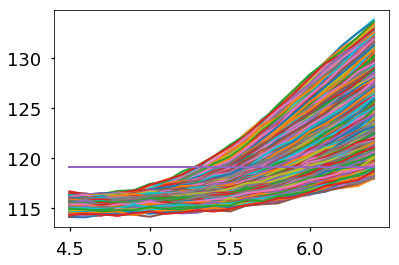

In [203]:
tslice = slice(45, 65)
arr = im_all[tslice,4,1,:,-10:10:-1].mean(axis=1)
tvec_tmp = tvec[tslice]
thresh = skimage.filters.threshold_li(arr)
_ = plt.plot(tvec_tmp,  arr)
_ = plt.plot([tvec_tmp[0], tvec_tmp[-1]], [thresh,thresh])

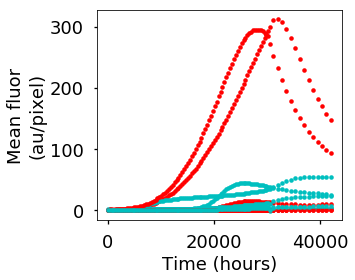

In [18]:
fig = plt.figure(figsize=(5,4))
bg_ind = df.pos == 1
bg_msc = df.loc[bg_ind, 'mscarlet'].values
bg_sfc = df.loc[bg_ind, 'sfcfp'].values
tmin = df.time.min()
for i in np.arange(3,9):
    ind = df.pos == i
    df_sub = df.loc[ind, :]
    tv = df_sub.time - tmin
    plt.plot(tv, df_sub.mscarlet.values - bg_msc, 'r.', lw=8)
    plt.plot(tv, df_sub.sfcfp.values - bg_sfc, 'c.', lw=8)
# plt.ylim([100,180])

plt.xlabel('Time (hours)')
plt.ylabel('Mean fluor\n(au/pixel)')
fig.tight_layout()
# fig.savefig("exp_constitutive.pdf")
# fig.savefig("exp_constitutive.png", dpi=150, transparent=True)

In [7]:
fig = plt.figure(figsize=(5,4))
for i in np.arange(3,9):
    plt.plot(tvec, im_all[:,i,1,:,:].mean(axis=1).mean(axis=1) - im_all[:,0,1,:,:].mean(axis=1).mean(axis=1)
             , 'r', lw=8)
    plt.plot(tvec,im_all[:,i,2,:,:].mean(axis=1).mean(axis=1) - im_all[:,0,2,:,:].mean(axis=1).mean(axis=1)
             , 'c')
# plt.ylim([100,180])

plt.xlabel('Time (hours)')
plt.ylabel('Mean mScarlet-I\nfluoresecence (au/pixel)')
fig.tight_layout()
# fig.savefig("exp_constitutive.pdf")
# fig.savefig("exp_constitutive.png", dpi=150, transparent=True)

NameError: name 'tvec' is not defined

<Figure size 360x288 with 0 Axes>

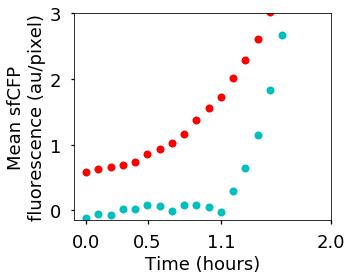

In [205]:
fig = plt.figure(figsize=(5,4))
imax = 20
bg_inds = df.pos == 5
t_min = df.time.min()
for i in np.arange(3,4):
    inds = df.pos == i 
    time_vec = (df.loc[inds, 'time'].values - t_min) / 3600
    plt.plot(time_vec, df.loc[inds, 'mscarlet'].values - df.loc[bg_inds, 'mscarlet'].values, 'r.',ms=16)
    plt.plot(time_vec, df.loc[inds, 'sfcfp'].values    - df.loc[bg_inds, 'sfcfp'].values, 'c.',ms=16)

df_sub = df.loc[(df.pos == 4 ) | (df.pos == 3 ), ['sfcfp', 'mscarlet', 'time']]
under_thresh = df_sub.loc[:,['sfcfp', 'mscarlet']] < 1
t1 = df_sub.loc[under_thresh['mscarlet'],'time'].max()

plt.xlim([-0.1,2])
plt.xticks([0, 0.5, 1.1, 2])
plt.ylim([-0.15,3])
plt.xlabel('Time (hours)')
plt.ylabel('Mean sfCFP\nfluorescence (au/pixel)')
plt.yticks(np.arange(0,4,1))
fig.tight_layout()
fig.savefig("exp_sender_receiver_delay.png", dpi=150, transparent=True)
fig.savefig("exp_sender_receiver_delay.pdf")
# plt.ylim([100,180])

In [206]:
.050 / (0.768 / 1024)

66.66666666666667

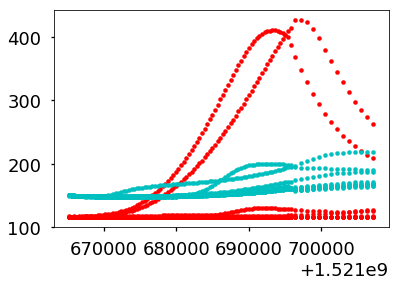

In [13]:
plt.plot(df.time, df.mscarlet, 'r.')
plt.plot(df.time, df.sfcfp, 'c.')

In [14]:
print(np.sqrt(np.sum(np.power(np.diff(positions_list[[3,5],:],axis=0),2)))/1e3)
print(np.sqrt(np.sum(np.power(np.diff(positions_list[[3,4],:],axis=0),2)))/1e3)

10.971059392784277
5.540600000000006
